**General fitting script**

_Covers:_
- _Typical TRKR_
- _Typical RSA_

# Initialization code (no editing required)

In [61]:
# Structure of this stuff cribbed from https://github.com/ageron/handson-ml
# General imports
import numpy as np
import scipy.ndimage.filters as filters
import scipy.stats as stats
# matplotlib setup for imaging...
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# code for notebook widgets
# note: scandata_browser keeps track of different scandata_list _objects_!
#       careful using something like
#            scandata_list = [scandata for scandata in scandata_list]
#       as this creates a brand new _list object_, even if the name is the same.
import ipywidgets as widgets
from textwrap import fill
scandata_list_list = []  # tracks _unique_ lists
scandata_list_config_list = []
def scandata_browser(scandata_list):  
    if not any([scandata_list is ref_list for ref_list in scandata_list_list]):  
        scandata_list_list.append(scandata_list)
        yfield = scandata_list[0].yfield
        scandata_list_config_list.append(
                {'pick_scandata_widget': widgets.IntSlider(min=0, max=len(scandata_list) - 1,
                                                           value=0, description='ScanData #:'),
                 'yfield_widget': widgets.Dropdown(options=[[yfield + ' [selected]', yfield]],
                                                   value=yfield, description='y-field:'),
                 })
    scandata_list_list_index = int(np.argwhere([scandata_list is ref_list for ref_list in scandata_list_list]))
    scandata_list_config = scandata_list_config_list[scandata_list_list_index]
    pick_scandata_widget = scandata_list_config['pick_scandata_widget']
    yfield_widget = scandata_list_config['yfield_widget']
    def scandata_index_update_callback(*args):
        pick_scandata_widget.max = len(scandata_list) - 1  # account for updates to list
        current_scandata = scandata_list[pick_scandata_widget.value]
        yfield_widget.options=[(field + ' [selected]' if field == current_scandata.yfield else field, field)
                               for field in current_scandata.get_nonx_nonerror_fields()]
    pick_scandata_widget.observe(scandata_index_update_callback, 'value')
    scandata_index_update_callback()
    def view_image(index, field):
        xvals, yvals, yerrvals = scandata_list[index].get_field_xyyerr(field)
        fig = plt.figure()
        ax = plt.subplot(111)
        if yerrvals is not None:
            ax.errorbar(xvals, yvals, yerrvals)
        else:
            ax.plot(xvals, yvals)
        plotlabel = '{}'.format(scandata_list[index].info.get('Filepath', index))
        ax.text(1.1, 0.9, fill(plotlabel, width=40), verticalalignment='top', horizontalalignment='left',
                transform=ax.transAxes, color='black', fontsize=16)
        plt.show()
    widgets.interact(view_image, index=pick_scandata_widget, field=yfield_widget)

# Global options

In [52]:
# OPTIONAL: edit matplotlab parameters
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Load data, specify details

In [62]:
from experimentdataanalysis.parsing.scandataparsing import fetch_dir_as_unfit_scandata_iterator

# TODO: some type of dialog box that lets one easily pick a dirpath and insert it into the text

# REQUIRED: selection of data directory
dirpath = ("C:\\Data\\august_data\\160902\\WavelengthDependence_TRKR_300mT")

# OPTIONAL: specification of specific columns in data file as x-coords, y-coords. Default: 1st column X, 2nd column Y.
data_xfield = None
data_yfield = 'lockin2x'

# OPTIONAL: specify a scalar value to be used as the measurement error of given y-values, i.e., their "error bars"
data_fixed_uncertainty = None

# fetch data
scandata_list = list(fetch_dir_as_unfit_scandata_iterator(
                     directorypath=dirpath, xfield=data_xfield, yfield=data_yfield, yfield_error_val=data_fixed_uncertainty))
processed_scandata_list = [scandata.copy() for scandata in scandata_list]  # for later; keep original untouched
print("Extracted {} ScanData from dir path".format(len(scandata_list)))

# clear old lists from browser widget, create new browser
for config_list in scandata_list_config_list:
    config_list['pick_scandata_widget'].close()
    config_list['yfield_widget'].close()
scandata_list_list = []
scandata_list_config_list = []
scandata_browser(scandata_list) if len(scandata_list) > 0 else None

Extracted 18 ScanData from dir path


# Data preprocessing (smoothing, filtering, etc.)

#  Model specification

## Select model and configure fit parameters

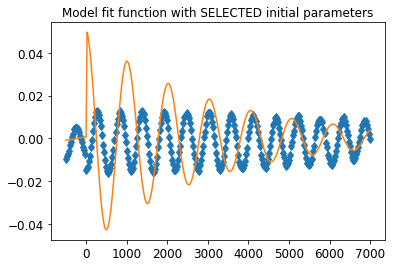

In [65]:
from fit_models_dnp_models import OneSpecies_NoDNP_TRKR_Model, OneSpecies_NoDNP_RSA_Model

model_choices = {'Basic TRKR': OneSpecies_NoDNP_TRKR_Model(),
                 'Basic RSA': OneSpecies_NoDNP_RSA_Model(),
                }

# REQUIRED: Choice of model, adjustment of initial parameters
model = model_choices['Basic TRKR']

model.model_params['pulse_amplitude'] = {'free': True,
                                         'initial value': 0.05,
                                         'bounds': (0, 1.0)}
model.model_params['spin_lifetime'] = {'free': True,
                                       'initial value': 3000,
                                       'bounds': (500, 8000)}
model.model_params['slope'] = {'free': True,
                               'initial value': 0}
model.model_params['bfield'] = {'free': False,
                                'initial value': 160}

# Optional: excluded intervals
# List of 2-tuples spanning areas to ignore during fit, e.g. [[-100, 200]] to avoid t=0 TRKR peak
model.excluded_intervals = None

# Optional: ignore weights
# If True, fit ignores the error values associated with data points, if there are any
model.ignore_weights = False

scandata_list_list_index = int(np.argwhere([scandata_list is ref_list for ref_list in scandata_list_list]))
scandata_list_config = scandata_list_config_list[scandata_list_list_index]
last_scandata_viewed = scandata_list[scandata_list_config['pick_scandata_widget'].value]
xvals = last_scandata_viewed.x
plt.plot(xvals, last_scandata_viewed.y, 'd')
plt.plot(xvals, model.fitfunction_with_initial_parameters(xvals))
plt.title('Model fit function with SELECTED initial parameters');

## [Optional]: Tweak model based on ScanData info

# Generate final figures

In [ ]:
import datetime, os

# OPTIONAL: edit where to save the final figures
PROJECT_ROOT_DIR = "."
SHARED_IMAGE_FOLDER = "generated images"
IMAGE_FOLDER = "General Fitting Script - " + datetime.datetime.now().ctime()

# define image saving function
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, SHARED_IMAGE_FOLDER, IMAGE_FOLDER, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Load and prepare Life satisfaction data

In [ ]:
import pandas as pd

# Download CSV from http://stats.oecd.org/index.aspx?DataSetCode=BLI
datapath = "datasets/lifesat/"

oecd_bli = pd.read_csv(datapath+"oecd_bli_2015.csv", thousands=',')
oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
oecd_bli.head(2)

In [ ]:
oecd_bli["Life satisfaction"].head()

# Load and prepare GDP per capita data

In [ ]:
# Download data from http://goo.gl/j1MSKe (=> imf.org)
gdp_per_capita = pd.read_csv(datapath+"gdp_per_capita.csv", thousands=',', delimiter='\t',
                             encoding='latin1', na_values="n/a")
gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
gdp_per_capita.set_index("Country", inplace=True)
gdp_per_capita.head(2)

In [ ]:
full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita, left_index=True, right_index=True)
full_country_stats.sort_values(by="GDP per capita", inplace="True")
full_country_stats

In [ ]:
full_country_stats[["GDP per capita", 'Life satisfaction']].loc["United States"]

In [ ]:
remove_indices = [0, 1, 6, 8, 33, 34, 35]
keep_indices = list(set(range(36)) - set(remove_indices))

sample_data = full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices]
missing_data = full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[remove_indices]

In [ ]:
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.axis([0, 60000, 0, 10])
position_text = {
    "Hungary": (5000, 1),
    "Korea": (18000, 1.7),
    "France": (29000, 2.4),
    "Australia": (40000, 3.0),
    "United States": (52000, 3.8),
}
for country, pos_text in position_text.items():
    pos_data_x, pos_data_y = sample_data.loc[country]
    country = "U.S." if country == "United States" else country
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "ro")
save_fig('money_happy_scatterplot')
plt.show()

In [ ]:
sample_data.loc[list(position_text.keys())]

In [ ]:
import numpy as np

sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.axis([0, 60000, 0, 10])
X=np.linspace(0, 60000, 1000)
plt.plot(X, 2*X/100000, "r")
plt.text(40000, 2.7, r"$\theta_0 = 0$", fontsize=14, color="r")
plt.text(40000, 1.8, r"$\theta_1 = 2 \times 10^{-5}$", fontsize=14, color="r")
plt.plot(X, 8 - 5*X/100000, "g")
plt.text(5000, 9.1, r"$\theta_0 = 8$", fontsize=14, color="g")
plt.text(5000, 8.2, r"$\theta_1 = -5 \times 10^{-5}$", fontsize=14, color="g")
plt.plot(X, 4 + 5*X/100000, "b")
plt.text(5000, 3.5, r"$\theta_0 = 4$", fontsize=14, color="b")
plt.text(5000, 2.6, r"$\theta_1 = 5 \times 10^{-5}$", fontsize=14, color="b")
save_fig('tweaking_model_params_plot')
plt.show()

In [ ]:
from sklearn import linear_model
lin1 = linear_model.LinearRegression()
Xsample = np.c_[sample_data["GDP per capita"]]
ysample = np.c_[sample_data["Life satisfaction"]]
lin1.fit(Xsample, ysample)
t0, t1 = lin1.intercept_[0], lin1.coef_[0][0]
t0, t1

In [ ]:
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.axis([0, 60000, 0, 10])
X=np.linspace(0, 60000, 1000)
plt.plot(X, t0 + t1*X, "b")
plt.text(5000, 3.1, r"$\theta_0 = 4.85$", fontsize=14, color="b")
plt.text(5000, 2.2, r"$\theta_1 = 4.91 \times 10^{-5}$", fontsize=14, color="b")
save_fig('best_fit_model_plot')
plt.show()


In [ ]:
cyprus_gdp_per_capita = gdp_per_capita.loc["Cyprus"]["GDP per capita"]
print(cyprus_gdp_per_capita)
cyprus_predicted_life_satisfaction = lin1.predict(cyprus_gdp_per_capita)[0][0]
cyprus_predicted_life_satisfaction

In [ ]:
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3), s=1)
X=np.linspace(0, 60000, 1000)
plt.plot(X, t0 + t1*X, "b")
plt.axis([0, 60000, 0, 10])
plt.text(5000, 7.5, r"$\theta_0 = 4.85$", fontsize=14, color="b")
plt.text(5000, 6.6, r"$\theta_1 = 4.91 \times 10^{-5}$", fontsize=14, color="b")
plt.plot([cyprus_gdp_per_capita, cyprus_gdp_per_capita], [0, cyprus_predicted_life_satisfaction], "r--")
plt.text(25000, 5.0, r"Prediction = 5.96", fontsize=14, color="b")
plt.plot(cyprus_gdp_per_capita, cyprus_predicted_life_satisfaction, "ro")
save_fig('cyprus_prediction_plot')
plt.show()

In [ ]:
sample_data[7:10]

In [ ]:
(5.1+5.7+6.5)/3

In [ ]:
backup = oecd_bli, gdp_per_capita

def prepare_country_stats(oecd_bli, gdp_per_capita):
    return sample_data

# Code example
########################################################################
import sklearn
import numpy as np
import pandas as pd

# Load the data
oecd_bli = pd.read_csv(datapath+"oecd_bli_2015.csv", thousands=',')
gdp_per_capita = pd.read_csv(datapath+"gdp_per_capita.csv", thousands=',',delimiter='\t',
                             encoding='latin1', na_values="n/a")

# Prepare the data
country_stats = prepare_country_stats(oecd_bli, gdp_per_capita)
X = np.c_[country_stats["GDP per capita"]]
y = np.c_[country_stats["Life satisfaction"]]

# Visualize the data
country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
plt.show()

# Select a linear model
lin_reg_model = sklearn.linear_model.LinearRegression()

# Train the model
lin_reg_model.fit(X, y)

# Make a prediction for Cyprus
X_new = [[22587]]  # Cyprus' GDP per capita
print(lin_reg_model.predict(X_new)) # outputs [[ 5.96242338]]
########################################################################

oecd_bli, gdp_per_capita = backup

In [ ]:
missing_data

In [ ]:
position_text2 = {
    "Brazil": (1000, 9.0),
    "Mexico": (11000, 9.0),
    "Chile": (25000, 9.0),
    "Czech Republic": (35000, 9.0),
    "Norway": (60000, 3),
    "Switzerland": (72000, 3.0),
    "Luxembourg": (90000, 3.0),
}

In [ ]:
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(8,3))
plt.axis([0, 110000, 0, 10])

for country, pos_text in position_text2.items():
    pos_data_x, pos_data_y = missing_data.loc[country]
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "rs")

X=np.linspace(0, 110000, 1000)
plt.plot(X, t0 + t1*X, "b:")

lin_reg_full = linear_model.LinearRegression()
Xfull = np.c_[full_country_stats["GDP per capita"]]
yfull = np.c_[full_country_stats["Life satisfaction"]]
lin_reg_full.fit(Xfull, yfull)

t0full, t1full = lin_reg_full.intercept_[0], lin_reg_full.coef_[0][0]
X = np.linspace(0, 110000, 1000)
plt.plot(X, t0full + t1full * X, "k")

save_fig('representative_training_data_scatterplot')
plt.show()

In [ ]:
full_country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(8,3))
plt.axis([0, 110000, 0, 10])

from sklearn import preprocessing
from sklearn import pipeline

poly = preprocessing.PolynomialFeatures(degree=60, include_bias=False)
scaler = preprocessing.StandardScaler()
lin_reg2 = linear_model.LinearRegression()

pipeline_reg = pipeline.Pipeline([('poly', poly), ('scal', scaler), ('lin', lin_reg2)])
pipeline_reg.fit(Xfull, yfull)
curve = pipeline_reg.predict(X[:, np.newaxis])
plt.plot(X, curve)
save_fig('overfitting_model_plot')
plt.show()

In [ ]:
full_country_stats.loc[[c for c in full_country_stats.index if "W" in c.upper()]]["Life satisfaction"]

In [ ]:
gdp_per_capita.loc[[c for c in gdp_per_capita.index if "W" in c.upper()]].head()

In [ ]:
plt.figure(figsize=(8,3))

plt.xlabel("GDP per capita")
plt.ylabel('Life satisfaction')

plt.plot(list(sample_data["GDP per capita"]), list(sample_data["Life satisfaction"]), "bo")
plt.plot(list(missing_data["GDP per capita"]), list(missing_data["Life satisfaction"]), "rs")

X = np.linspace(0, 110000, 1000)
plt.plot(X, t0full + t1full * X, "r--", label="Linear model on all data")
plt.plot(X, t0 + t1*X, "b:", label="Linear model on partial data")

ridge = linear_model.Ridge(alpha=10**9.5)
Xsample = np.c_[sample_data["GDP per capita"]]
ysample = np.c_[sample_data["Life satisfaction"]]
ridge.fit(Xsample, ysample)
t0ridge, t1ridge = ridge.intercept_[0], ridge.coef_[0][0]
plt.plot(X, t0ridge + t1ridge * X, "b", label="Regularized linear model on partial data")

plt.legend(loc="lower right")
plt.axis([0, 110000, 0, 10])
save_fig('ridge_model_plot')
plt.show()

In [ ]:
backup = oecd_bli, gdp_per_capita

def prepare_country_stats(oecd_bli, gdp_per_capita):
    return sample_data

# Code example
########################################################################
from sklearn import neighbors
import numpy as np
import pandas as pd

# Load the data
oecd_bli = pd.read_csv(datapath+"oecd_bli_2015.csv", thousands=',')
gdp_per_capita = pd.read_csv(datapath+"gdp_per_capita.csv", thousands=',',delimiter='\t',
                             encoding='latin1', na_values="n/a")

# Prepare the data
country_stats = prepare_country_stats(oecd_bli, gdp_per_capita)
X = np.c_[country_stats["GDP per capita"]]
y = np.c_[country_stats["Life satisfaction"]]

# Visualize the data
country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
plt.show()

# Select a k-neighboors regression model
k_neigh_reg_model = neighbors.KNeighborsRegressor(n_neighbors=3)

# Train the model
k_neigh_reg_model.fit(X, y)

# Make a prediction for Cyprus
X_new = [[22587]]  # Cyprus' GDP per capita
print(lin_reg_model.predict(X_new)) # outputs [[ 5.96242338]]
########################################################################

oecd_bli, gdp_per_capita = backup